In [1]:
#Inital imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases
from lifetimes import BetaGeoFitter, GammaGammaFitter
from datetime import timedelta
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
!ls data

OnlineRetail_2yrs.csv             lifetimes_object_df.csv
customer_data_base.zip            lifetimes_object_df_uncleaned.csv


In [3]:
#Load in our pre-prepared dataframes
lifetimes_object_df = pd.read_csv("data/lifetimes_object_df.csv")

### Preparation and evaluation functions

In [4]:
#Load in our data wrangler
from lifetimes.utils import summary_data_from_transaction_data
#Import holdout 
from lifetimes.utils import calibration_and_holdout_data

In [5]:
#class to return a calibration and holdout df
class df_ch():
    def __init__(self, eval_period=None,transaction_df=None,purchase_timestamp_col=None,customer_id_col=None,datetime_col=None,monetary_value_col=None):
        #initialized attributes
        self.eval_period = eval_period
        self.transaction_df = transaction_df
        self.purchase_timestamp_col=purchase_timestamp_col
        self.customer_id_col=customer_id_col
        self.datetime_col=datetime_col
        self.monetary_value_col=monetary_value_col
        #save off more attributes
        self.min_obs_date = parser.parse(transaction_df[purchase_timestamp_col].min())
        self.max_obs_date = parser.parse(transaction_df[purchase_timestamp_col].max())
        self.max_calib_date = self.max_obs_date - timedelta(days=eval_period)  
        self.calib_range_days = (self.max_calib_date - self.min_obs_date).days
    def df_ch_getdf(self):
        df = calibration_and_holdout_data(
        transactions = self.transaction_df, 
        customer_id_col=self.customer_id_col,
        datetime_col=self.datetime_col,
        monetary_value_col=self.monetary_value_col,
        calibration_period_end = self.max_calib_date, 
        observation_period_end = self.max_obs_date, 
        freq = "D")
        return df
        

In [6]:
#function to return a df of real and predicted transacitons in eval period
def bgf_real_v_pred_df(ch,bgf):
    rfm_cal_holdout = pd.DataFrame()
    ch_df = ch.df_ch_getdf()
    rfm_cal_holdout["n_transactions_cal_real"]  = ch_df["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    rfm_cal_holdout["n_transactions_holdout_real"]  = ch_df["frequency_holdout"] #Total validation days with purchases = validation frequency
    # the predicted number of transactions
    rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=ch.eval_period, 
                                                    frequency=ch_df['frequency_cal'], 
                                                    recency=ch_df['recency_cal'], 
                                                    T=ch_df['T_cal'])
    return rfm_cal_holdout[["n_transactions_cal_real","n_transactions_holdout_real", "n_transactions_holdout_pred"]]

In [7]:
#function to capture RMSE for a BGF model
def bgf_rmse(ch,bgf):
    df_ch = ch.df_ch_getdf()
    df_ch["n_transactions_holdout_real"] = df_ch["frequency_holdout"]
    y_true = df_ch["n_transactions_holdout_real"]
    y_pred = bgf.predict(t=ch.eval_period, frequency=df_ch['frequency_cal'],
                         recency=df_ch['recency_cal'],
                         T=df_ch['T_cal'])

    return mean_squared_error(y_true,y_pred)

In [8]:
#function to return predicted # transactions for given customer in evaluation period
def samp_cust_pred_trans(df_ch,sample_customer_id,eval_period):
    sample_customer = df_ch.loc[sample_customer_id]
    n_transactions_pred = bgf.predict(t=eval_period,
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])
    return(n_transactions_pred)

In [9]:
#Dummy model function that predicts the same purchase rate in the observation period to continue through the eval period
def bgf_dummy_model(ch):
    df_ch = ch.df_ch_getdf()
    dummy_ch_df = pd.DataFrame()
    dummy_ch_df["purchases_per_period_cal"] = df_ch["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch.calib_range_days #Purchase rate
    dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch.eval_period #Predicting purchase rate to continue
    dummy_ch_df["actual_purchases_holdout"] = df_ch["frequency_holdout"] #Total validation days with purchases = validation frequency
    return mean_squared_error(y_true=dummy_ch_df["dummy_pred_purchases_holdout"],y_pred=dummy_ch_df["actual_purchases_holdout"])


In [10]:
#function to return a df of real and predicted transacitons in eval period for dummy model
def bgf_dummy_real_v_pred_df(ch):
    df_ch = ch.df_ch_getdf()
    dummy_ch_df = pd.DataFrame()
    dummy_ch_df["purchases_per_period_cal"] = df_ch["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch.calib_range_days #Purchase rate
    dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch.eval_period #Predicting purchase rate to continue
    dummy_ch_df["actual_purchases_holdout"] = df_ch["frequency_holdout"] #Total validation days with purchases = validation frequency
    return dummy_ch_df

### RFM data exploration 

In [11]:
summary = summary_data_from_transaction_data(transactions=lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value',observation_period_end='2018-10-17')
summary

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,160.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,163.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,586.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,370.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,337.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,496.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,311.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,617.0,0.0


In [12]:
#We have less than 3% of customers who are repeat purchasers
summary.frequency.value_counts(normalize=True)

0.0     0.978261
1.0     0.020097
2.0     0.001305
3.0     0.000189
4.0     0.000063
5.0     0.000053
6.0     0.000021
15.0    0.000011
Name: frequency, dtype: float64

In [13]:
summary.frequency.value_counts()

0.0     92924
1.0      1909
2.0       124
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: frequency, dtype: int64

In [14]:
#create a list of repeat purchasers
repeat_purchaser_ids = list(summary[summary["frequency"] >= 1].index)
#subset our transaction data to just repeat purchasers
repeat_lifetimes_object_df = lifetimes_object_df[lifetimes_object_df["customer_unique_id"].isin(repeat_purchaser_ids) == True]
#Checking we removed the correct number of user id's
(len(lifetimes_object_df.customer_unique_id.unique()) - len(repeat_lifetimes_object_df.customer_unique_id.unique())) == summary.frequency.value_counts()[0]

True

In [15]:
repeat_purchaser_summary = summary_data_from_transaction_data(transactions=repeat_lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value',observation_period_end='2018-10-17')


In [77]:
#Calculate the time between purchases
inter_purchase_period = []
for customer in repeat_purchaser_summary.index:
    inter_purchase_period.append((repeat_purchaser_summary.loc[customer].recency/repeat_purchaser_summary.loc[customer].frequency))
avg_inter_purchase_period = sum(inter_purchase_period)/len(inter_purchase_period)
avg_inter_purchase_period

113.9720823244552

In [81]:
#From the documentation, for optimal fit, the training date range should cover at least 3 
#but hopefully 5-10 inter-purchase periods
#The holdout period should be at least half the training period
total_date_range = (repeat_lifetimes_object_df["order_purchase_timestamp"].max() - repeat_lifetimes_object_df["order_purchase_timestamp"].min()).days
total_date_range

700

In [120]:
def get_eval_period(
def objective_function(test_period):
    return sdfs
minimize()

In [105]:
# An inter_period_multiple of 4 works well and gives us a holdout period of about 240 days
inter_period_multiple = 4
print(f'holdout period given {inter_period_multiple} inter period multiple: {total_date_range-(avg_inter_purchase_period*4)}')

holdout period given 4 inter period multiple: 244.1116707021792


In [16]:
#The Gamma-Gamma submodel, assumes no relationship between the monetary value and the purchase frequency. 
#The correlation between the two vectors is close to 0 so we can use this model.
repeat_purchaser_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.00000,-0.00049
frequency,-0.00049,1.00000


In [17]:
#Load in our ch object with all data
ch_1 = df_ch(eval_period=240,transaction_df=lifetimes_object_df,purchase_timestamp_col='order_purchase_timestamp',
                   customer_id_col='customer_unique_id',datetime_col='order_purchase_timestamp',
                   monetary_value_col='payment_value')

In [18]:
#Load in our ch object with repeat purchaser data
ch_2 = df_ch(eval_period=240,transaction_df=repeat_lifetimes_object_df,purchase_timestamp_col='order_purchase_timestamp',
                   customer_id_col='customer_unique_id',datetime_col='order_purchase_timestamp',
                   monetary_value_col='payment_value')

In [19]:
#create an array to evaluate total purchases per customer in calib period
repeat_lifetimes_object_df_ts = repeat_lifetimes_object_df
repeat_lifetimes_object_df_ts["order_purchase_timestamp"] = pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"])
purchases_in_cal = repeat_lifetimes_object_df_ts[repeat_lifetimes_object_df_ts["order_purchase_timestamp"]<=ch_2.max_calib_date]
purchases_in_cal = purchases_in_cal[purchases_in_cal["order_purchase_timestamp"]<=ch_2.max_calib_date].groupby("customer_unique_id").nunique()["order_purchase_timestamp"]
purchases_in_cal.sort_values()
purchases_in_cal = pd.DataFrame(purchases_in_cal)
purchaser_id_in_cal = list(purchases_in_cal.index)

In [20]:
#create an array to evaluate total purchases per customer in validation period
purchases_in_val = repeat_lifetimes_object_df_ts[repeat_lifetimes_object_df_ts["order_purchase_timestamp"]>ch_2.max_calib_date].groupby("customer_unique_id").nunique()["order_purchase_timestamp"]
purchases_in_val.sort_values()
purchases_in_val = pd.DataFrame(purchases_in_val)
#subset to just those id's that appeared in our calib period
purchases_in_val = purchases_in_val[purchases_in_val.index.isin(purchaser_id_in_cal)]
purchases_in_val

,order_purchase_timestamp
customer_unique_id,
004288347e5e88a27ded2bb23747066c,1
004b45ec5c64187465168251cd1c9c2f,1
011b4adcd54683b480c4d841250a987f,1
012452d40dafae4df401bced74cdb490,1
0178b244a5c281fb2ade54038dd4b161,1
...,...
fc19fe9ac733e36ff8227c29435c2030,1
fcd0ab79592faab19e2bf386cf69fbcd,1
fe3e52de024b82706717c38c8e183084,1


In [21]:
df_ch_2 = ch_2.df_ch_getdf()

In [22]:
#Confirming that a 'frequency' of 0.00 in calibration period means total purchases in that period = 1
#Total calibration days with purchases = calibration frequency + 1
purch = []
for purchasers in df_ch_2["frequency_cal"]:    
    purch.append(purchasers+1)
sum(purch) == purchases_in_cal["order_purchase_timestamp"].sum()

True

In [23]:
#Attempting on holdout group
#False bc these are repeat customers so we don't need to add +1
purch = []
for purchasers in df_ch_2["frequency_holdout"]:    
    purch.append(purchasers+1)
sum(purch) == purchases_in_val["order_purchase_timestamp"].sum()

False

In [24]:
#Total validation days with purchases = validation frequency
sum(df_ch_2["frequency_holdout"]) == purchases_in_val["order_purchase_timestamp"].sum()

True

###  Dummy model
Model features
- Predict purchases in holdout period based on the observed purchase rate in the calibration period
Model results
- Decent RMSE for all customers
- Poor RMSE for repeat customer subset
- We significantly improved upon our dummy model

In [25]:
print(f' bgf dummy model RMSE w/ all data: {bgf_dummy_model(ch_1)}')
print(f' bgf dummy model RMSE w/ repeat cust only: {bgf_dummy_model(ch_2)}')

 bgf dummy model RMSE w/ all data: 0.25709468684945536
 bgf dummy model RMSE w/ repeat cust only: 0.8141615765376924


In [26]:
dummy_ch_df = pd.DataFrame()
dummy_ch_df["purchases_per_period_cal"] = df_ch_2["frequency_cal"] + 1
#533 is the calib range
dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/533
dummy_ch_df["value_per_purchase_cal"] = df_ch_2["monetary_value_cal"] / (df_ch_2["frequency_cal"] + 1)
#240 is the eval range
dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * 240
dummy_ch_df["actual_purchases_holdout"] = df_ch_2["frequency_holdout"] + 1
dummy_ch_df

,purchases_per_period_cal,value_per_purchase_cal,dummy_pred_purchases_holdout,actual_purchases_holdout
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,0.001876,0.000000,0.450281,2.0
004b45ec5c64187465168251cd1c9c2f,0.001876,0.000000,0.450281,2.0
011b4adcd54683b480c4d841250a987f,0.001876,0.000000,0.450281,2.0
012452d40dafae4df401bced74cdb490,0.001876,0.000000,0.450281,2.0
013f4353d26bb05dc6652f1269458d8d,0.003752,82.020000,0.900563,1.0
...,...,...,...,...
fe59d5878cd80080edbd29b5a0a4e1cf,0.005629,13.200000,1.350844,1.0
fe81bb32c243a86b2f86fbf053fe6140,0.003752,31.890000,0.900563,4.0
fed519569d16e690df6f89cb99d4e682,0.001876,0.000000,0.450281,2.0


###  1.0 BG/NBD model
Model features
- All customers including those with just 1 purchase

Model results
- Very strong RMSE
- We significantly improved upon our dummy model

Next steps
- Attempt on subsetted data of customers with more than 1 purchase

In [27]:
#Iniatialze df_ch 
df_ch_1 = ch_1.df_ch_getdf()

In [28]:
#Iniatialize bgf model
bgf_1 = BetaGeoFitter(penalizer_coef=0)

In [29]:
#Fit model to df_ch
bgf_1.fit(
        frequency = df_ch_1["frequency_cal"], 
        recency = df_ch_1["recency_cal"], 
        T = df_ch_1["T_cal"],   
        weights = None,  
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.065817
         Iterations: 60
         Function evaluations: 63
         Gradient evaluations: 63


<lifetimes.BetaGeoFitter: fitted with 44463 subjects, a: 1.85, alpha: 55.22, b: 0.32, r: 0.02>

In [30]:
bgf_1_rmse = bgf_rmse(ch_1,bgf_1)
bgf_1_rmse

0.020255570402409388

/Applications/anaconda3/envs/lifetime-env/lib/python3.10/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


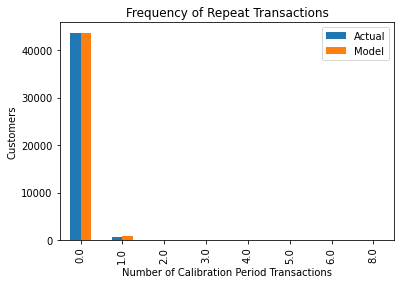

In [31]:
#Our model accurately esimates n purchases with in the calibation period
plot_period_transactions(bgf_1);

<Figure size 504x504 with 0 Axes>

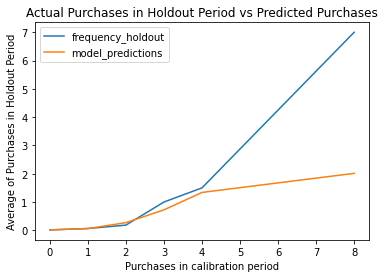

In [32]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7))
plot_calibration_purchases_vs_holdout_purchases(bgf_1, df_ch_1);

###  2.0 BG/NBD model
Model features
- Subsetted data of customers with more than 1 purchase

Model results
- Our model is less accurate on this subset of repeat customers bc we can't inflate accuracy with the signficant n of correct 0 purchase perdictions that 
- That said, this model did much better than our dummy model did on repeat customers

Next steps
- Attempt regularization

In [33]:
#Iniatialze df_ch 
df_ch_2 = ch_2.df_ch_getdf()

In [34]:
#Iniatialize bgf model
bgf_2 = BetaGeoFitter(penalizer_coef=0)

In [35]:
#Fit model to df_ch
bgf_2.fit(
        frequency = df_ch_2["frequency_cal"], 
        recency = df_ch_2["recency_cal"], 
        T = df_ch_2["T_cal"],   
        weights = None,  
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.095057
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31


<lifetimes.BetaGeoFitter: fitted with 1384 subjects, a: 1.82, alpha: 135.02, b: 0.25, r: 1.13>

In [36]:
bgf_2_rmse = bgf_rmse(ch_2,bgf_2)
bgf_2_rmse

0.254995983388962

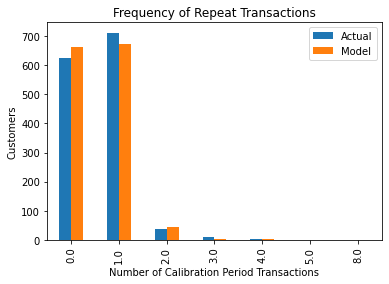

In [37]:
plot_period_transactions(bgf_2);

<Figure size 504x504 with 0 Axes>

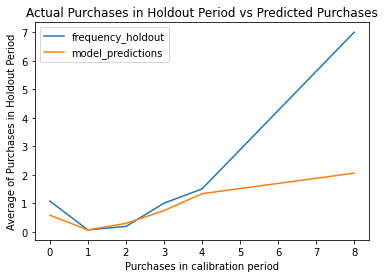

In [38]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf_2, df_ch_2);

###  3.0 BG/NBD model
Model features
- Subsetted data of customers with more than 1 purchase
- Regularization in the form of l2 penalty

Model results
- Zero regularization produced the best result

Next steps
- Attempt regularization on full data set

In [39]:
#Documentation says that penalties in the order of 0.001 to 0.1 are effective
penalizer_coef_grid = {"bgf_3_0":0,"bgf_3_001":0.001,"bgf_3_05":0.05,"bgf_3_01":.01,"bgf_3_015":.015}
for penalizer in penalizer_coef_grid:
    model = BetaGeoFitter(penalizer_coef=penalizer_coef_grid[penalizer])
    model.fit(
        frequency = df_ch_2["frequency_cal"], 
        recency = df_ch_2["recency_cal"], 
        T = df_ch_2["T_cal"],   
        weights = None,  
        verbose = False)
    print(f'{penalizer} {bgf_rmse(ch_2,model)}')

bgf_3_0 0.254995983388962
bgf_3_001 0.2554724458875201
bgf_3_05 0.38414252555643896
bgf_3_01 0.2950368840677332
bgf_3_015 0.3111396102838008


###  4.0 BG/NBD model
Model features
- All customers including those with just 1 purchase
- Regularization in the form of l2 penalty

Model results
- Zero regularization produced the best result

Next steps
- Bring in a Gama Gama model to predict LTV


In [40]:
for penalizer in penalizer_coef_grid:
    model = BetaGeoFitter(penalizer_coef=penalizer_coef_grid[penalizer])
    model.fit(
        frequency = df_ch_1["frequency_cal"], 
        recency = df_ch_1["recency_cal"], 
        T = df_ch_1["T_cal"],   
        weights = None,  
        verbose = False)
    print(f'{penalizer} {bgf_rmse(ch_1,model)}')

bgf_3_0 0.020255570402409388
bgf_3_001 0.02159426531842805
bgf_3_05 0.026885903278818842
bgf_3_01 0.024215553556762578
bgf_3_015 0.024818318495397666


###  1.0 GG model
Model features
- All customers including those with just 1 purchase
- No regularization

Model results
- TBD


In [146]:
#subset the summary data to just return customers, GG models do not accept a freq of zero
return_cust_summary = summary[summary["frequency"]>0]
return_cust_summary.head(3)

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,447.0,103.28
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,411.0,49.85
00a39521eb40f7012db50455bf083460,1.0,11.0,147.0,26.78


In [169]:
ggf_1 = GammaGammaFitter(penalizer_coef = 0)
#fit to return customer summary
ggf.fit(frequency=return_cust_summary["frequency"],monetary_value=return_cust_summary["monetary_value"])


<lifetimes.GammaGammaFitter: fitted with 2065 subjects, p: 5.95, q: 2.80, v: 46.29>

In [172]:
conditional_expected_average_profit = ggf.conditional_expected_average_profit(frequency=return_cust_summary["frequency"],monetary_value=return_cust_summary["monetary_value"])
conditional_expected_average_profit

customer_unique_id
004288347e5e88a27ded2bb23747066c    114.784000
004b45ec5c64187465168251cd1c9c2f     73.781302
00a39521eb40f7012db50455bf083460     56.077162
011575986092c30523ecb71ff10cb473     97.164274
011b4adcd54683b480c4d841250a987f    150.545289
                                       ...    
fed519569d16e690df6f89cb99d4e682    120.140519
ff03923ad1eb9e32304deb7f9b2a45c9    130.324045
ff22e30958c13ffe219db7d711e8f564    163.268941
ff8892f7c26aa0446da53d01b18df463     86.742851
ff922bdd6bafcdf99cb90d7f39cea5b3     63.598742
Length: 2065, dtype: float64

In [171]:
mean_squared_error(y_true=return_cust_summary["monetary_value"],y_pred=conditional_expected_average_profit)

1361.5689939757717

In [152]:
# refit the BG model to the summary_with_money_value dataset
bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])


,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,160.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,163.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,586.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,370.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,337.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,496.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,311.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,617.0,0.0


#### Attempting to validate the performance of the GG model

In [128]:
df_ch_2_subset = df_ch_2[df_ch_2["monetary_value_cal"]>0]
df_ch_2_subset = df_ch_2_subset[df_ch_2_subset["monetary_value_holdout"]>0]
df_ch_2_subset.head(3)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
041caba6a63ace5818387698ea85cdb2,1.0,247.0,297.0,51.73,1.0,71.78,240.0
083ca1aa470c280236380973a48f77c6,2.0,19.0,162.0,86.96,1.0,105.29,240.0
0b18593e033697810a62a987e77f4b8c,1.0,12.0,218.0,73.34,1.0,63.13,240.0


In [126]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(frequency=df_ch_2_subset["frequency_cal"],monetary_value=df_ch_2_subset["monetary_value_cal"])

<lifetimes.GammaGammaFitter: fitted with 51 subjects, p: 4.90, q: 2.81, v: 64.30>

In [137]:
ggf.conditional_expected_average_profit(frequency=df_ch_2_subset["frequency_holdout"],monetary_value=df_ch_2_subset["monetary_value_holdout"])

customer_unique_id
041caba6a63ace5818387698ea85cdb2     99.374134
083ca1aa470c280236380973a48f77c6    123.845132
0b18593e033697810a62a987e77f4b8c     93.057389
1b6c7548a2a1f9037c1fd3ddfed95f33    176.384223
1da09dd64e235e7c2f29a4faff33535c    653.538896
2ddc001b620bd90d0f4378cfde1db887    123.538423
30a81e307f19e822e7199139fe52b1b0     88.011296
32ea3bdedab835c3aa6cb68ce66565ef     72.456767
35ecdf6858edc6427223b64804cf028e    111.905388
3e43e6105506432c953e165fb2acf44c    111.619726
3e5306add1209e5ba184092dd1587282    120.230347
3ea4185126195c34ed9949d8e406d570    105.574038
455c17b35969ca198c17f2fc9e8eba1b    235.326555
47c1a3033b8b77b3ab6e109eb4d5fdf3     91.297464
4bbaf6f7a10a7e26a8777aa5cb6d5864     82.877571
4e65032f1f574189fb793bac5a867bbc     84.681312
4f4d2fe2987efa0b9e4e61a466e8ed8b     88.142742
5e8f38a9a1c023f3db718edcf926a2db    139.859724
5f45aa4ef9b8fb99b95d33a970bb64a7     96.810923
6204c4e582a95b6a350adf6988623bfb    145.898970
63cfc61cee11cbe306bff5857d00bfe4    113.8

In [138]:
mean_squared_error(y_true=df_ch_2_subset["monetary_value_holdout"],y_pred=ggf.conditional_expected_average_profit(frequency=df_ch_2_subset["frequency_holdout"],monetary_value=df_ch_2_subset["monetary_value_holdout"]))

1334.2813385562738

In [141]:
mean_squared_error(y_true=df_ch_2_subset["monetary_value_holdout"],y_pred=df_ch_2_subset["monetary_value_cal"])


37162.99154594201